In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct

from catch22 import catch22_all

from scipy.io import wavfile




def read_arduino(ser,inputBufferSize):
#     data = ser.readline((inputBufferSize+1)*2)
    data = ser.read((inputBufferSize+1)*2)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return np.flip(np.array(result)-512)



# ser.read works by waiting for <inputBufferSize> bytes from the port

def read_arduinbro(wav_array, inputBufferSize, k):
#    data = ser.readline(inputBufferSize)
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)




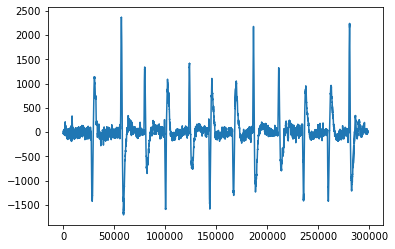

In [2]:

# path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Eye Data/"

path = 'C:/Users/David/Documents/Data3888/Aqua10/Datasets/Eye Data/'

file = "left-right"


samprate, wav_array = wavfile.read(path+file+".wav")


plt.plot(wav_array)




In [3]:
# Load in labels


labels = pd.read_csv(path+file+"..txt", sep=",\t", skiprows=1)

labels.columns = ["label", "time"]

# Change depending on whether L is coded as 1 or as 2
labels.label = ["L" if label == 1 else "R" for label in labels.label]

labels

<ipython-input-3-0635028947ac>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels = pd.read_csv(path+file+"..txt", sep=",\t", skiprows=1)


,label,time
0,L,2.8675
1,R,5.4405
2,R,7.7814
3,L,9.9956
4,R,12.2611
5,L,14.4050
6,L,16.6543
7,R,18.8625
8,R,20.9803
9,L,23.1502


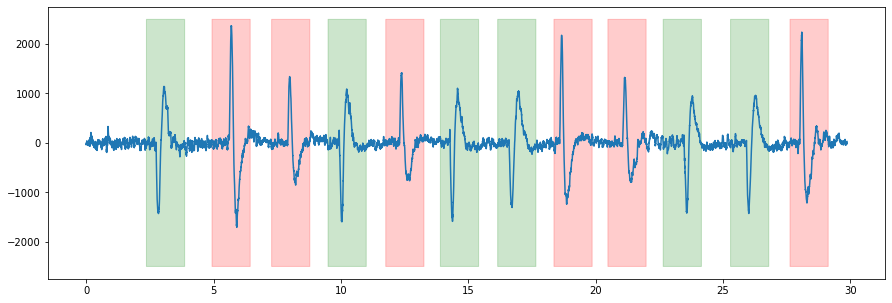

In [4]:
time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

before_buffer = 0.5
after_buffer = 1

left_events_bool = np.array([False]*len(time_seq))
for time in labels.time[labels.label == "L"]:
    left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    
right_events_bool = np.array([False]*len(time_seq))
for time in labels.time[labels.label == "R"]:
    right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool


plt.figure(figsize=(15, 5))
    
plt.plot(time_seq, wav_array)

plt.fill_between(time_seq, 2500, -2500,
                 where = left_events_bool,
                 color = 'g',
                 alpha=0.2)

plt.fill_between(time_seq, 2500, -2500,
                 where = right_events_bool,
                 color = 'r',
                 alpha=0.2)




# plt.fill_betweenx(ys, start_times, end_times,
#                  facecolor="orange", # The fill color
#                  color='blue',       # The outline color
#                  alpha=0.2)          # Transparency of the fill



In [ ]:
# # Livestreaming data


# # use this to find ports
# import serial
# from serial.tools import list_ports


# ports = list_ports.comports()
# for port in ports:
#     print(port)
    

    
# samprate = 20000
# inputBufferSize = 10000

# # Read example data
# baudrate = 230400
# cport = '/dev/cu.usbmodem142301'  # set the correct port before you run it
# ser = serial.Serial(port=cport, baudrate=baudrate)   

features = catch22_all(wav_array)
print(features['names'])
print(features['values'])


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

values = features["values"]
print(values)

X = np.array(values)
X = X.reshape(1,-1)
print(X)

# define feature selection
fs = SelectKBest(score_func=f_classif, k=2)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

In [ ]:

# SINCE THE STREAMING DATA COMES IN FROM THE RIGHT TO THE LEFT ON THE PLOT, 
# THE RESULTANT PLOT IS ACTUALLY REFLECTED ABOUT THE Y AXIS


samprate = 20000

%matplotlib notebook


# Things you can change:
window_size = 1.5; # time plotted in window [s]
N_loops_over_window = 16 # implicityly defines buffer size so that its 1/<N_loops_over_window>ths of a window

# Things you shouldn't need to change:
inputBufferSize = int(window_size/N_loops_over_window * samprate)

total_time = len(wav_array)/samprate; # time in seconds [[1 s = 20000 buffer size]]
N_loops =(total_time*samprate)//inputBufferSize  # len(wav_array)//inputBufferSize 
T_acquire = inputBufferSize/samprate    # length of time that data is acquired for 
N_loops_over_window = window_size/T_acquire    # total number of loops to cover desire time window



print("total_time", total_time)
print("window_size", window_size)
print("N_loops", N_loops)
print("T_acquire", T_acquire)
print("N_loops_over_window", N_loops_over_window)




# Initialise plot
min_y = -2500 #np.min(wav_array)
max_y = 2500 #np.max(wav_array)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()



for k in range(0,int(N_loops)):
    
    # Simulate stream
    data_temp = read_arduinbro(wav_array, inputBufferSize, k)

    # Stream
#     data = read_arduino(ser,inputBufferSize)
#     data_temp = process_data(data)
    

    if k < N_loops_over_window:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
            
        continue
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
        
    
    
    ## PLOT ###
    
    
    t = (min(k+1,N_loops_over_window))*inputBufferSize/samprate*np.linspace(0,1,(data_plot).size)
    ax1.clear()
    ax1.set_xlim(0, window_size)
    ax1.set_ylim(min_y, max_y)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    fig.canvas.draw()    
    plt.show()


